In [3]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
accidents = pd.read_csv('../input/Accident_Information.csv')
print('Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])
accidents.head()

Records: 2047256 
Columns: 34


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,2005-01-04,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.489096,Daylight,Kensington and Chelsea,Kensington and Chelsea,525680.0,178240.0,-0.191170,E01002849,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No


In [5]:
accidents['Date']= pd.to_datetime(accidents['Date'], format="%Y-%m-%d")

In [6]:
accidents.iloc[:, 5:13].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 8 columns):
Accident_Severity                              object
Carriageway_Hazards                            object
Date                                           datetime64[ns]
Day_of_Week                                    object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                               object
Junction_Detail                                object
Latitude                                       float64
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 125.0+ MB


In [7]:
# slice first and second string from time column
accidents['Hour'] = accidents['Time'].str[0:2]

# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

In [8]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "evening (19-23)"
    else:
        return "night (23-5)"

In [9]:
accidents['Daytime'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Daytime']].head(8)

,Time,Hour,Daytime
0,17:42,17,afternoon rush (15-19)
1,17:36,17,afternoon rush (15-19)
2,00:15,0,night (23-5)
3,10:35,10,office hours (10-15)
4,21:13,21,evening (19-23)
5,12:40,12,office hours (10-15)
6,20:40,20,evening (19-23)
7,17:35,17,afternoon rush (15-19)


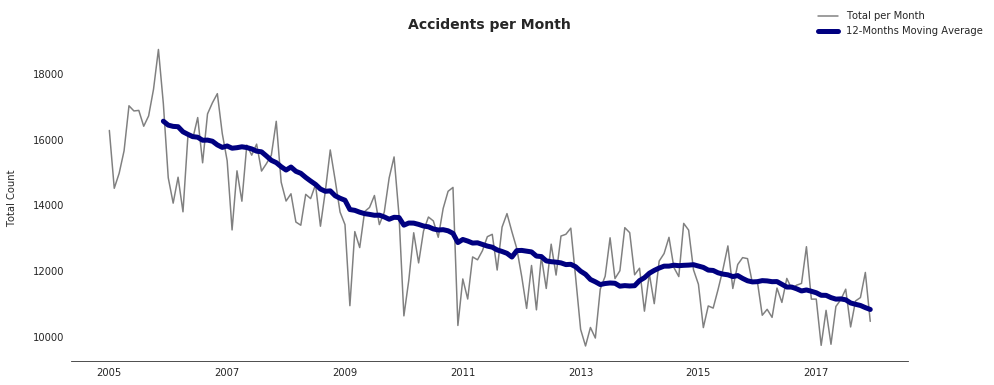

In [30]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,6))

# plot
accidents.set_index('Date').resample('M').size().plot(label='Total per Month', color='grey', ax=ax)
accidents.set_index('Date').resample('M').size().rolling(window=12).mean()\
                           .plot(color='navy', linewidth=5, label='12-Months Moving Average', ax=ax)

ax.set_title('Accidents per Month', fontsize=14, fontweight='bold')
ax.set(ylabel='Total Count\n', xlabel='')
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False);

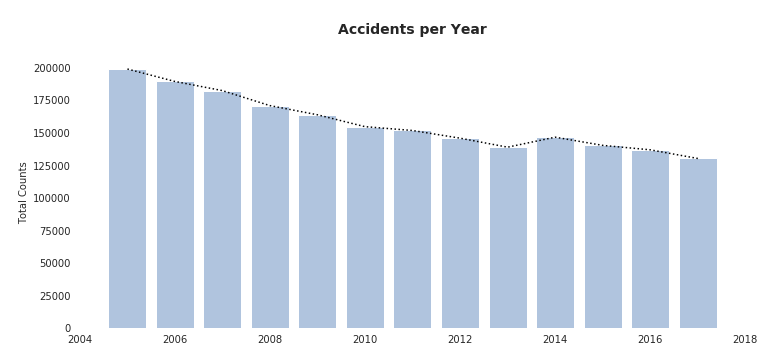

In [12]:
yearly_count = accidents['Date'].dt.year.value_counts().sort_index(ascending=False)

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))

# plot
ax.bar(yearly_count.index, yearly_count.values, color='lightsteelblue')
ax.plot(yearly_count, linestyle=':', color='black')
ax.set_title('\nAccidents per Year\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Counts')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

**On which weekdays are accidents most likely to be caused?**

In [13]:
weekday_counts = pd.DataFrame(accidents.set_index('Date').resample('1d')['Accident_Index'].size().reset_index())
weekday_counts.columns = ['Date', 'Count']
#weekday_counts

weekday = weekday_counts['Date'].dt.weekday_name
#weekday

weekday_averages = pd.DataFrame(weekday_counts.groupby(weekday)['Count'].mean().reset_index())
weekday_averages.columns = ['Weekday', 'Average_Accidents']
weekday_averages.set_index('Weekday', inplace=True)
weekday_averages

,Average_Accidents
Weekday,
Friday,494.345133
Monday,428.410029
Saturday,402.254786
Sunday,331.821797
Thursday,454.595870
Tuesday,451.721239
Wednesday,455.089971


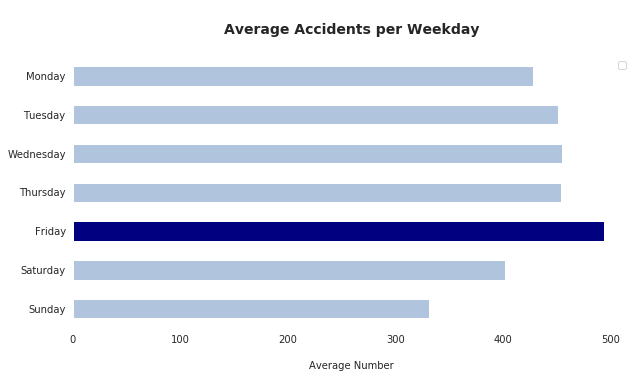

In [14]:
days = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,5))
colors=['lightsteelblue', 'lightsteelblue', 'navy', 'lightsteelblue', 
        'lightsteelblue', 'lightsteelblue', 'lightsteelblue']

# plot
weekday_averages.reindex(days).plot(kind='barh', ax=ax, color=[colors])
ax.set_title('\nAverage Accidents per Weekday\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nAverage Number', ylabel='')
ax.legend('')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

In [15]:
weekday = accidents['Date'].dt.weekday_name
year    = accidents['Date'].dt.year

accident_table = accidents.groupby([year, weekday]).size()
accident_table = accident_table.rename_axis(['Year', 'Weekday'])\
                               .unstack('Weekday')\
                               .reindex(columns=days)
accident_table

Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday
Year,,,,,,,
2005,21905,26943,32734,29732,30365,29217,27810
2006,21440,25977,31992,28149,28106,27338,26141
2007,20384,24681,29260,27301,27295,26924,26250
2008,18748,23047,27384,24947,25828,26242,24379
2009,17860,22158,26666,24302,24796,24788,22967
2010,16794,20819,25475,22807,23016,23045,22450
2011,16272,20002,24945,23458,22924,22470,21391
2012,15855,19302,23509,22334,21996,21660,20910
2013,14854,18026,23044,21184,20459,21255,19830


- Plotting this second dataframe:

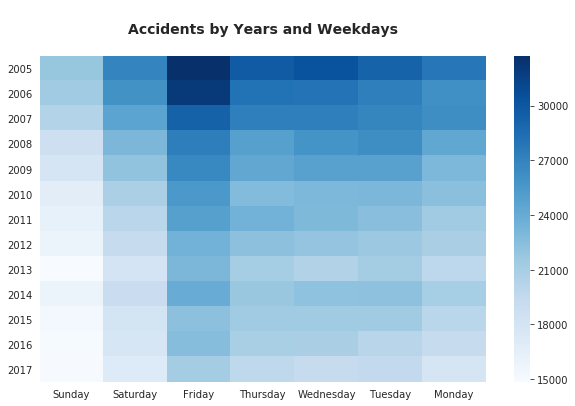

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(accident_table, cmap='Blues')
plt.title('\nAccidents by Years and Weekdays\n', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('');

***How are accidents related to weather conditions?***

In [17]:
accidents.Weather_Conditions.value_counts(normalize=True)

Fine no high winds              0.801123
Raining no high winds           0.116881
Other                           0.021531
Unknown                         0.020765
Raining + high winds            0.013844
Fine + high winds               0.012610
Snowing no high winds           0.006539
Fog or mist                     0.005406
Snowing + high winds            0.001214
Data missing or out of range    0.000085
Name: Weather_Conditions, dtype: float64

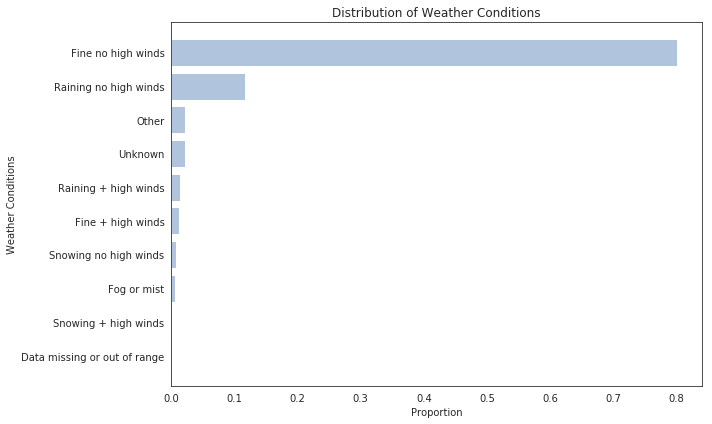

In [34]:
import matplotlib.pyplot as plt

weather_conditions = {
    "Fine no high winds": 0.801123,
    "Raining no high winds": 0.116881,
    "Other": 0.021531,
    "Unknown": 0.020765,
    "Raining + high winds": 0.013844,
    "Fine + high winds": 0.012610,
    "Snowing no high winds": 0.006539,
    "Fog or mist": 0.005406,
    "Snowing + high winds": 0.001214,
    "Data missing or out of range": 0.000085
}

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(weather_conditions.keys()), list(weather_conditions.values()), color="lightsteelblue")
plt.xlabel("Proportion")
plt.ylabel("Weather Conditions")
plt.title("Distribution of Weather Conditions")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


***What percentage of each category of accident severity do we have?***

In [18]:
accidents.Accident_Severity.value_counts()

Slight     1734422
Serious     286311
Fatal        26367
Name: Accident_Severity, dtype: int64

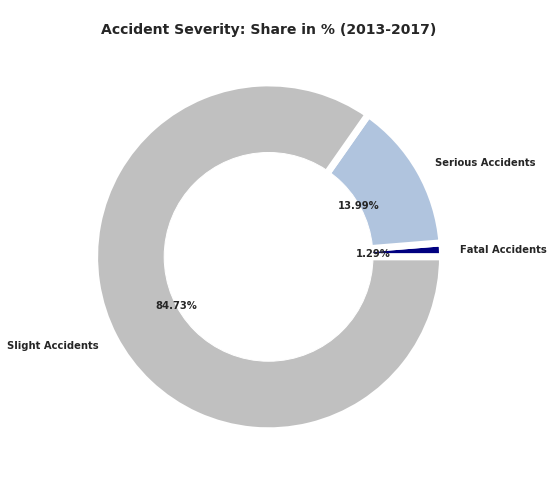

In [19]:
# assign the data
fatal   = accidents.Accident_Severity.value_counts()['Fatal']
serious = accidents.Accident_Severity.value_counts()['Serious']
slight  = accidents.Accident_Severity.value_counts()['Slight']

names = ['Fatal Accidents','Serious Accidents', 'Slight Accidents']
size  = [fatal, serious, slight]
#explode = (0.2, 0, 0)

# create a pie chart
plt.pie(x=size, labels=names, colors=['navy', 'lightsteelblue', 'silver'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(8,8)
fig.gca().add_artist(my_circle)
plt.title('\nAccident Severity: Share in % (2013-2017)', fontsize=14, fontweight='bold')
plt.show()

***How has the number of fatalities developed over the years?***

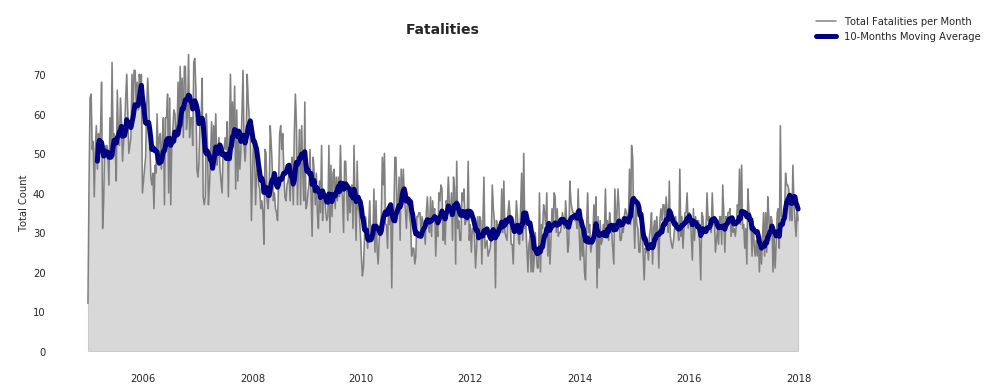

In [29]:
# set the criterium to slice the fatalaties
criteria = accidents['Accident_Severity']=='Fatal'
# create a new dataframe
weekly_fatalities = accidents.loc[criteria].set_index('Date').sort_index().resample('W').size()

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,6))

# plot
weekly_fatalities.plot(label='Total Fatalities per Month', color='grey', ax=ax)
plt.fill_between(x=weekly_fatalities.index, y1=weekly_fatalities.values, color='grey', alpha=0.3)
weekly_fatalities.rolling(window=10).mean()\
                           .plot(color='navy', linewidth=5, label='10-Months Moving Average', ax=ax)

ax.set_title('\nFatalities', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Count', xlabel='')
ax.legend(bbox_to_anchor=(1.2, 1.1), frameon=False)

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

***Is the share of fatal accidents increasing or decreasing?***

In [21]:
sub_df = accidents[['Date', 'Accident_Index', 'Accident_Severity']]

# pull out the year
year = sub_df['Date'].dt.year
week = sub_df['Date'].dt.week

# groupby year and severities
count_of_fatalities = sub_df.set_index('Date').groupby([pd.Grouper(freq='W'), 'Accident_Severity']).size()

# build a nice table
fatalities_table = count_of_fatalities.rename_axis(['Week', 'Accident_Severity'])\
                                      .unstack('Accident_Severity')\
                                      .rename({1:'fatal', 2:'serious', 3:'slight'}, axis='columns')
fatalities_table.head()

Accident_Severity,Fatal,Serious,Slight
Week,,,
2005-01-02,12,101,501
2005-01-09,42,378,2728
2005-01-16,64,460,3340
2005-01-23,65,464,3616
2005-01-30,51,433,3454


In [22]:
fatalities_table['sum'] = fatalities_table.sum(axis=1)
fatalities_table = fatalities_table.join(fatalities_table.div(fatalities_table['sum'], axis=0), rsuffix='_percentage')
fatalities_table.head()

Accident_Severity,Fatal,Serious,Slight,sum,Fatal_percentage,Serious_percentage,Slight_percentage,sum_percentage
Week,,,,,,,,
2005-01-02,12,101,501,614,0.019544,0.164495,0.815961,1.0
2005-01-09,42,378,2728,3148,0.013342,0.120076,0.866582,1.0
2005-01-16,64,460,3340,3864,0.016563,0.119048,0.864389,1.0
2005-01-23,65,464,3616,4145,0.015682,0.111942,0.872376,1.0
2005-01-30,51,433,3454,3938,0.012951,0.109954,0.877095,1.0


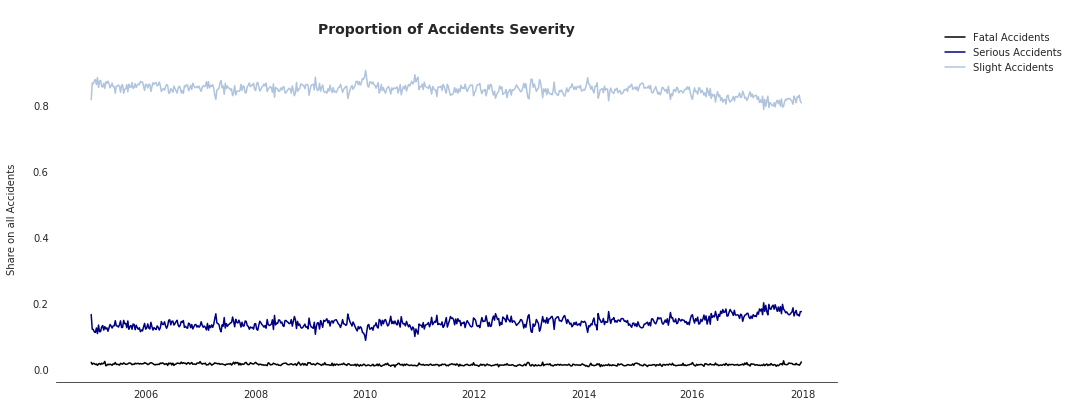

In [23]:
# prepare data
sub_df = fatalities_table[['Fatal_percentage', 'Serious_percentage', 'Slight_percentage']]

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,6))
colors=['black', 'navy', 'lightsteelblue']

# plot
sub_df.plot(color=colors, ax=ax)
ax.set_title('\nProportion of Accidents Severity\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Share on all Accidents\n', xlabel='')
ax.legend(labels=['Fatal Accidents', 'Serious Accidents', 'Slight Accidents'], 
          bbox_to_anchor=(1.3, 1.1), frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=False);

*The trend for fatal accidents seems to stagnate.*

***How are accidents distributed throughout the day?***

- Distribution of Hours

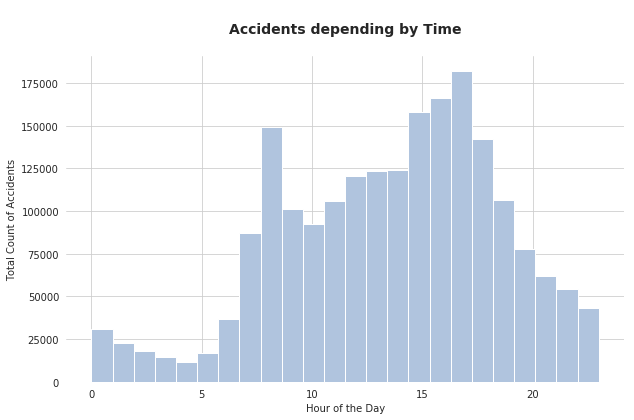

In [24]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))

# plot
accidents.Hour.hist(bins=24, ax=ax, color='lightsteelblue')
ax.set_title('\nAccidents depending by Time\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Hour of the Day', ylabel='Total Count of Accidents')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

- Counts of Accidents by Daytime

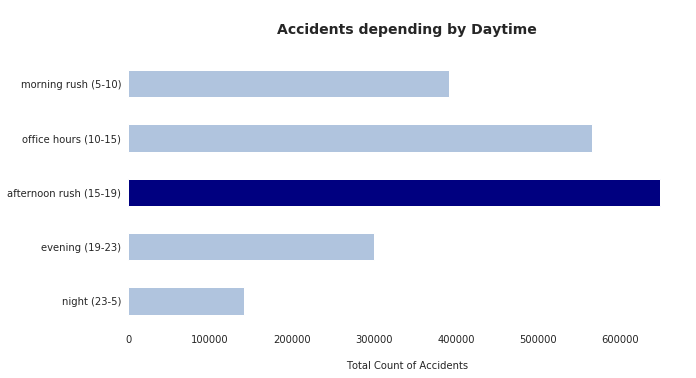

In [25]:
# prepare dataframe
order = ['night (23-5)', 'evening (19-23)', 'afternoon rush (15-19)', 'office hours (10-15)', 'morning rush (5-10)']
df_sub = accidents.groupby('Daytime').size().reindex(order)

# prepare barplot
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['lightsteelblue', 'lightsteelblue', 'navy', 'lightsteelblue', 'lightsteelblue']

# plot
df_sub.plot(kind='barh', ax=ax, color=colors)
ax.set_title('\nAccidents depending by Daytime\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nTotal Count of Accidents', ylabel='')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

- Share of Accident Severity by Daytime

In [26]:
# prepare dataframe with simple counts
counts = accidents.groupby(['Daytime', 'Accident_Severity']).size()

counts = counts.rename_axis(['Daytime', 'Accident_Severity'])\
                                .unstack('Accident_Severity')\
                                .rename({1:'fatal', 2:'serious', 3:'slight'}, axis='columns')
counts

Accident_Severity,Fatal,Serious,Slight
Daytime,,,
afternoon rush (15-19),6545,89651,552154
evening (19-23),4898,47268,248457
morning rush (5-10),4169,48807,338083
night (23-5),4336,26853,109697
office hours (10-15),6419,73732,486031


In [27]:
# prepare dataframe with shares
counts['sum'] = counts.sum(axis=1)
counts = counts.join(counts.div(counts['sum'], axis=0), rsuffix=' in %')
counts_share = counts.drop(columns=['Fatal', 'Serious', 'Slight', 'sum', 'sum in %'], axis=1)
counts_share

Accident_Severity,Fatal in %,Serious in %,Slight in %
Daytime,,,
afternoon rush (15-19),0.010095,0.138276,0.851630
evening (19-23),0.016293,0.157233,0.826474
morning rush (5-10),0.010661,0.124807,0.864532
night (23-5),0.030777,0.190601,0.778622
office hours (10-15),0.011337,0.130227,0.858436


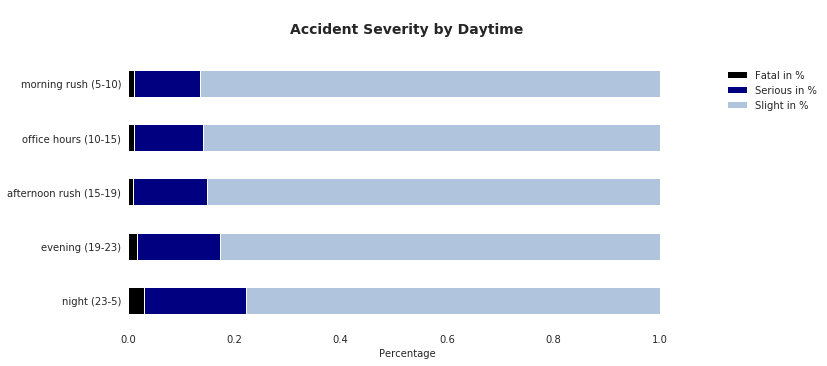

In [32]:
# prepare barplot
fig, ax = plt.subplots(figsize=(10, 5))

# define custom colors for 'fatal', 'serious', and 'slight'
custom_colors = ['black', 'navy', 'lightsteelblue']
# plot
counts_share.reindex(order).plot(kind='barh', ax=ax, stacked=True, color=custom_colors)
ax.set_title('\nAccident Severity by Daytime\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Percentage', ylabel='')
ax.legend(bbox_to_anchor=(1.25, 0.98), frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True)
